## Step 2: Quasi-conformal spherical parameterization of a genus-0 surface, $S_{ref}(x,y,z)$ 

Any genus-0 surface can be mapped to a sphere. Various different ways to do this have been proposed in the literature. This workbook will work through our implementation of the approach of [Choi et al.](https://arxiv.org/abs/1203.6819) which guarantees a bijective mapping with no foldovers.


### Load $S_{ref}(x,y,z)$  mesh and create an analysis save folder

We assume the user has worked through step 1 which generates and saves genus-0 reference surface for an input cell surface mesh to the folder `example_results/bleb_example/step1_cMCF_reference`. Moreover this surface has been colored by curvature or molecular intensity. 

In [11]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import scipy.io as spio

# example cell used
imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step2_confocal_sphere_param')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


# load the pre-computed genus-0 reference surface mesh for the cell
S_ref_folder = 'example_results/%s/step1_cMCF_reference' %(basefname)
S_ref_file = os.path.join(S_ref_folder, 
                            'unwrap_cMCF_Sref_mesh_H_color.obj') 
mesh = meshtools.read_mesh(S_ref_file)


### Conformal mapping of  $S_{ref}(x,y,z)$  mesh onto the 3D sphere to get $S_{\mathcal{Q}}(x,y,z)$

The conformal spherical mapping of [Choi et al.](https://arxiv.org/abs/1203.6819) consists two steps. The first step is a direct spherical mapping. The problem is that because of the rotational symmetry of the sphere many of the vertices 'shifts' towards one spot. This artifact is more extreme the more the original shape deviates from the sphere. The second step aims to correct for this using a Mobius transformation.   

In [12]:
# explicitly expose the vertex and faces.
v = mesh.vertices.copy()
f = mesh.faces.copy()

""" 
Initial spherical parametrization
""" 
sphere_xyz = meshtools.direct_spherical_conformal_map(v,f) # gives just the vertices.
sphere_mesh = mesh.copy() # this helps to copy the existing colormap
sphere_mesh.vertices = sphere_xyz.copy()

tmp = sphere_mesh.export(os.path.join(savefolder, 'initial_sphere_param_Sref_%s.obj' %(basefname)))

"""
Mobius area correction to get final conformal parameterization
"""
sphere_xyz_conformal = meshtools.mobius_area_correction_spherical(v,
                                                               f,
                                                               sphere_xyz)

sphere_conformal = mesh.copy() # this helps to copy the existing colormap
sphere_conformal.vertices = sphere_xyz_conformal.copy()

tmp = sphere_conformal.export(os.path.join(savefolder, 'conformal_sphere_param_Sref_%s.obj' %(basefname)))


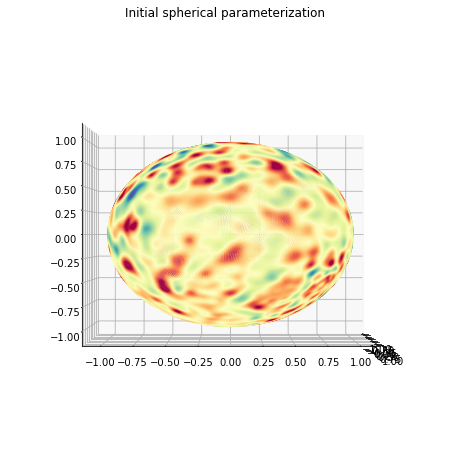

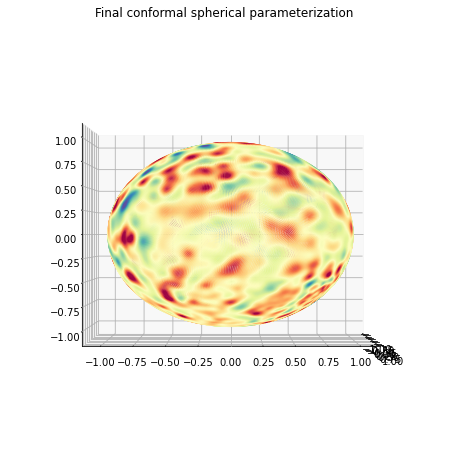

In [13]:
"""
Plotting using matplotlib for comparison. The final version should have vertices more evenly distributed over the sphere. 
"""
import unwrap3D.Visualisation.plotting as plotting 
import pylab as plt 

sampling = 1 # plot every just so its not fully dense in the plot so we don't see anything!

# plotting the before
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('Initial spherical parameterization')
ax.scatter(sphere_mesh.vertices[::sampling,2], 
           sphere_mesh.vertices[::sampling,1],
           sphere_mesh.vertices[::sampling,0], 
           s=0.5,
           c=sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
plt.show()

# plotting the after
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('Final conformal spherical parameterization')
ax.scatter(sphere_conformal.vertices[::sampling,2], 
           sphere_conformal.vertices[::sampling,1],
           sphere_conformal.vertices[::sampling,0], 
           s=0.5,
           c=sphere_mesh.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
plt.show()

### Quantifying and colormapping the conformal and equiareal distortion error of the spherical parameterization

In [16]:
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

"""
Conformal error
"""
conformal_error = meshtools.quasi_conformal_error(v, 
                                                  sphere_xyz_conformal, 
                                                  f)
# color the error
conformal_error_colors = vol_colors.get_colors(conformal_error[1], colormap=cm.jet, vmin=1., vmax=1.5)

sphere_conformal_error = meshtools.create_mesh(vertices=sphere_xyz_conformal,
                                               faces=f,
                                               face_colors=np.uint8(255*conformal_error_colors[...,:3]))
tmp = sphere_conformal_error.export(os.path.join(savefolder, 
                                           'conformal_sphere_param_Sref_%s_conformal-error.obj' %(basefname)))

"""
Area distortion error
"""
area_distortion_error = meshtools.area_distortion_measure(v, 
                                                          sphere_xyz_conformal, 
                                                          f)  
area_distortion_error_colors = vol_colors.get_colors(np.log(area_distortion_error), 
                                                     colormap=cm.coolwarm, 
                                                     vmin=-3, 
                                                     vmax=3)

sphere_areal_error = sphere_conformal_error.copy()
sphere_areal_error.visual.face_colors = np.uint8(255*area_distortion_error_colors[...,:3]).copy()
tmp = sphere_areal_error.export(os.path.join(savefolder, 
                                       'conformal_sphere_param_Sref_%s_log_equiareal-error.obj' %(basefname)))

# save the statistics
spio.savemat(os.path.join(savefolder, 
                          'conformal_sphere-param_conformal_area_errors.mat'), 
                          {'conformal_Jac_eigvals': conformal_error[0], 
                          'conformal_stretch_factors': conformal_error[1], 
                          'mean_conformal_stretch_factors': conformal_error[2], 
                          'conformal_tri_area_pairs': conformal_error[3], 
                          'conformal_area_distortion_factor': area_distortion_error})

## We now proceed to step 3 notebook to obtain an quasi-equiareal spherical parameterization of the genus-0 reference shape ...